In [29]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import StandardScaler

In [30]:
np.random.seed(42)

TRAIN_PERCENTAGE = 0.8
VALIDATION_PERCENTAGE = 0.2
OUTPUT_LENGTH = 3

In [31]:
def load_iris_data():
    from sklearn.datasets import load_iris

    data = load_iris()
    inputs = data['data']
    outputs = data['target']
    outputNames = data['target_names']
    featureNames = list(data['feature_names'])

    inputs = [[feat[featureNames.index('sepal length (cm)')], feat[featureNames.index('petal length (cm)')]] for feat in inputs]

    return inputs, outputs, outputNames

In [32]:
def create_output(output):
    return [0.9 if output == i else 0.1 for i in range(OUTPUT_LENGTH)]

In [33]:
inputs, outputs, outputNames = load_iris_data()
outputs = [create_output(output) for output in outputs]

In [34]:
def split_data(inputs, outputs):
    indexes = list(range(len(inputs)))
    train_sample = np.random.choice(indexes, int(TRAIN_PERCENTAGE * len(inputs)), replace = False)
    test_sample = [i for i in indexes if not i in train_sample]
    validation_sample = np.random.choice(train_sample, int(VALIDATION_PERCENTAGE * len(train_sample)), replace = False)
    train_sample = [i for i in train_sample if not i in validation_sample]

    train_inputs = [inputs[i] for i in train_sample]
    train_outputs = [outputs[i] for i in train_sample]

    validation_inputs = [inputs[i] for i in validation_sample]
    validation_outputs = [outputs[i] for i in validation_sample]

    test_inputs = [inputs[i] for i in test_sample]
    test_outputs = [outputs[i] for i in test_sample]

    return train_inputs, train_outputs, validation_inputs, validation_outputs, test_inputs, test_outputs

In [35]:
def normalisation(trainData, validationData, testData):
    scaler = StandardScaler()
    if not isinstance(trainData[0], list):
        trainData = [[d] for d in trainData]
        validationData = [[d] for d in validationData]
        testData = [[d] for d in testData]

        scaler.fit(trainData)
        normalisedTrainData = scaler.transform(trainData)
        normalisedValidationData = scaler.transform(validationData)
        normalisedTestData = scaler.transform(testData)

        trainData = [d[0] for d in trainData]
        validationData = [d[0] for d in validationData]
        testData = [d[0] for d in testData]
    else:
        scaler.fit(trainData)
        normalisedTrainData = scaler.transform(trainData)
        normalisedValidationData = scaler.transform(validationData)
        normalisedTestData = scaler.transform(testData)
    
    return normalisedTrainData, normalisedValidationData, normalisedTestData

In [36]:
def create_set(inputs, outputs):
    return [[input, output] for input, output in zip(inputs, outputs)]

In [37]:
train_inputs, train_outputs, validation_inputs, validation_outputs, test_inputs, test_outputs = split_data(inputs, outputs)
train_inputs, validation_inputs, test_inputs = normalisation(train_inputs, validation_inputs, test_inputs)

train_set = create_set(train_inputs, train_outputs)
validation_set = create_set(validation_inputs, validation_outputs)
test_set = create_set(test_inputs, test_outputs)

In [38]:
def flatten_outputs(outputs):
    return [np.argmax(output) for output in outputs]

In [39]:
def plot_features(inputs, outputs, feature1 = 'feature 1', feature2 = 'feature2'):
    outputs = flatten_outputs(outputs)
    labels = set(outputs)
    no_data = len(inputs)

    for label in labels:
        x = [inputs[i][0] for i in range(no_data) if outputs[i] == label]
        y = [inputs[i][1] for i in range(no_data) if outputs[i] == label]
        plt.scatter(x, y, label = outputNames[label])
    
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.legend()
    plt.show()

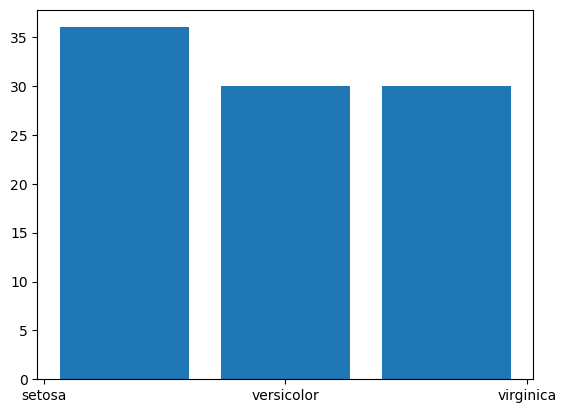

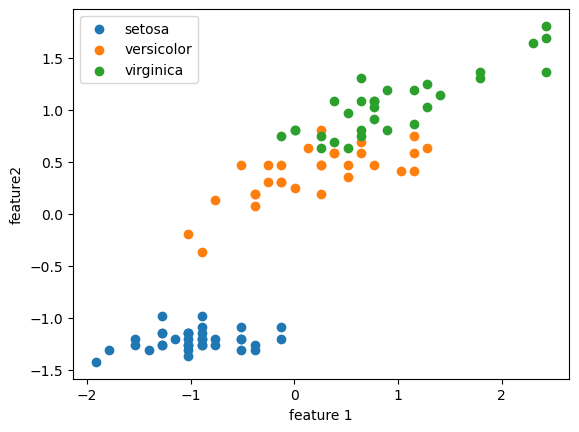

In [40]:
plt.hist(flatten_outputs(train_outputs), 3, rwidth = 0.8)
plt.xticks(np.arange(len(outputNames)), outputNames)
plt.show()

plot_features(train_inputs, train_outputs)

In [41]:
class Function:

    def __call__(self, x):
        raise NotImplementedError

    def derivative(self, x):
        raise NotImplementedError

class IdentityFunction(Function):

    def __call__(self, x):
        return x 
    
    def derivative(self, x):
        return 1 

class SigmoidFunction(Function):

    def __call__(self, x):
        if x < -100:
            x = -100
        elif x > 100:
            x = 100
        return 1 / (1 + math.pow(math.e, -x))
    
    def derivative(self, x):
        return self.__call__(x) * (1 - self.__call__(x))

class ReluFunction(Function):

    def __call__(self, x):
        return x if x >= 0 else 0
    
    def derivative(self, x):
        return 1 if x > 0 else 0

class SeluFunction(Function):

    def __init__(self, lambdaa = 1.0507, alpha = 1.6732):
        self.__lambda = lambdaa
        self.__alpha = alpha

    def __call__(self, x):
        if x >= 0:
            return self.__lambda * x
        
        return self.__lambda * self.__alpha * (math.exp(x) - 1)
    
    def derivative(self, x):
        if x >= 0:
            return self.__lambda
        
        return self.__lambda * self.__alpha * math.exp(x)

In [42]:
class Node:
    
    def __init__(self, no_weights, function = IdentityFunction(), lr = 0.03):
        self._weights =  list((0.1 * np.random.random_sample((1, no_weights + 1)) - 0.05)[0])
        self._lr = lr 
        self._function = function
        self._no_weights = no_weights

    def get_weights(self):
        return self._weights
    
    def get_function(self):
        return self._function

    def set_lr(self, lr):
        self._lr = lr

    def apply(self, instance):
        assert len(self._weights) - 1 == len(instance)
        return self._function(self._weights[0] + np.dot(self._weights[1:], instance))
    
    def derivative(self, instance):
        return self._function.derivative(self._weights[0] + np.dot(self._weights[1:], instance))
    
    def update_weights(self, instance, error):
        assert len(self._weights[1:]) == len(instance)

        for j in range(1, self._no_weights):
            self._weights[j] = self._weights[j] + self._lr * error * instance[j - 1]

In [43]:
class InputNode(Node):
    def __init__(self, no_weights = 2, function = IdentityFunction(), lr = 0.03):
        super().__init__(no_weights, function, lr)
        self._weights = [0, 1]


In [44]:
class OutputNode(Node):
    def __init__(self, no_weights = 2, function = IdentityFunction(), lr = 0.03):
        super().__init__(no_weights, function, lr)
        self._error = None

    def reset_error(self):
        self._error = None

    def error(self, instance, target):
        if self._error != None:
            return self._error

        value = self.apply(instance)

        self._error = self._function.derivative(value) * (target - value)
        return self._error
    
    def update_weights(self, instance, error):
        for j in range(1, self._no_weights):
            self._weights[j] = self._weights[j] + self._lr * error * instance[j - 1]

In [45]:
class Layer:

    def __init__(self, no_previous_nodes, no_nodes, function = IdentityFunction(), lr = 0.03, name = 'Layer'):
        self._nodes = [Node(no_previous_nodes, function, lr) for _ in range(no_nodes)]

        self._next_layer = None
        self._no_weights = no_previous_nodes
        self._no_nodes = no_nodes
        self._name = name
        self._errors = None
    
    def get_name(self):
        return self._name

    def get_no_nodes(self):
        return self._no_nodes

    def get_no_weights(self):
        return self._no_weights
    
    def get_nodes(self):
        return self._nodes

    def get_weights(self):
        return [node.get_weights() for node in self._nodes]

    def get_next_layer(self):
        return self._next_layer

    def set_lr(self, lr):
        for node in self._nodes:
            node.set_lr(lr)
    
    def reset_error(self):
        self._errors = None

    def apply(self, instance):
        return [node.apply(instance) for node in self._nodes]
    
    def derivative(self, instance):
        return [node.derivative(instance) for node in self._nodes]
    
    def errors(self, instance, target = None):
        if self._errors != None:
            return self._errors

        errors = []
        next_errors = self._next_layer.errors(self.apply(instance), target)
        next_nodes = self._next_layer.get_nodes()

        assert len(next_nodes) == len(next_errors)

        for i in range(len(self._nodes)):
            derivative = self._nodes[i].derivative(instance)
            errors.append(derivative * sum([node.get_weights()[i + 1] * error for node, error in zip(next_nodes, next_errors)]))
        
        self._errors = errors
        return errors
    
    def update_weights(self, instance, target = None):
        errors = self.errors(instance, target)
        
        assert len(self._nodes) == len(errors)
        for node, error in zip(self._nodes, errors):
            node.update_weights(instance, error)

    def add_next_layer(self, layer):
        assert self._no_nodes == layer.get_no_weights()

        if self._no_nodes != layer.get_no_weights():
            raise Exception("Invalid number of nodes")

        self._next_layer = layer

In [46]:
class InputLayer(Layer):

    def __init__(self, no_nodes, function = IdentityFunction(), lr = 0.03, no_previous_nodes = 0, name = 'Input'):
        super().__init__(no_previous_nodes, no_nodes, function, lr, name)

        self._nodes = [InputNode()] * no_nodes

In [47]:
class OutputLayer(Layer):
    def __init__(self, no_nodes, function = IdentityFunction(), lr = 0.03, no_previous_nodes = 0, name = 'Output'):
        super().__init__(no_previous_nodes, no_nodes, function, lr, name)

        self._nodes = [OutputNode(no_previous_nodes, function, lr) for _ in range(no_nodes)]
    
    def reset_error(self):
        self._errors = None
        for node in self._nodes:
            node.reset_error()
    
    def errors(self, instance, targets = None):
        if self._errors != None:
            return self._errors

        self._errors = [node.error(instance, target) for node, target in zip(self.get_nodes(), targets)]
        return self._errors

    def update_weights(self, instance, targets):
        assert len(self._nodes) == len(targets)
        self.errors(instance, targets)

        for node, error in zip(self.get_nodes(), self._errors):
            node.update_weights(instance, error)

In [48]:
def get_max( v):
    maximum = 0
    pos = -1

    for i in range(len(v)):
        if v[i] > maximum:
            maximum = v[i]
            pos = i
    
    return pos

In [49]:
class Model:

    def __init__(self, lr = 0.03, epochs = 10):
        self.__first_layer = None 
        self.__lr = lr
        self.__epochs = epochs
    
    def add_layer(self, layer):
        layer.set_lr(self.__lr)
        if self.__first_layer == None:
            self.__first_layer = layer
        else:
            current_layer = self.__first_layer
            while current_layer.get_next_layer() != None:
                current_layer = current_layer.get_next_layer()
            current_layer.add_next_layer(layer)
    
    def get_input_layer_result(self, instance):
        return [node.apply([instance_value]) for node, instance_value in zip(self.__first_layer.get_nodes(), instance)]

    def get_weights(self):
        weights = []
        current_layer = self.__first_layer

        while current_layer != None:
            weights.append(current_layer.get_weights())
            current_layer = current_layer.get_next_layer()

        return weights

    def reset_error(self):
        current_layer = self.__first_layer.get_next_layer()

        while current_layer != None:
            current_layer.reset_error()
            current_layer = current_layer.get_next_layer()

    def apply(self, instance):
        current_instance = instance
        current_layer = self.__first_layer.get_next_layer()
        
        while current_layer != None:
            current_instance = current_layer.apply(current_instance)
            current_layer = current_layer.get_next_layer()
        
        return current_instance
    
    def get_output_weights(self):
        current_layer = self.__first_layer.get_next_layer()
        
        while current_layer.get_next_layer() != None:
            current_layer = current_layer.get_next_layer()
        
        return current_layer.get_weights()
    
    def update_weights_model(self, instance, target):
        layer = self.__first_layer.get_next_layer()

        inputs = [instance]
        layers = []
        contor = 0

        while layer != None:
            inputs.append(layer.apply(inputs[contor]))
            layers.append(layer)
            layer = layer.get_next_layer()
            contor += 1

        contor -= 1 

        while contor >= 0:
            layer = layers[contor]
            input = inputs[contor]
            
            if layer.get_next_layer() == None:
                layer.update_weights(input, target)
            else:
                layer.update_weights(input, None) 
            
            contor -= 1


    def accuracy(self, instances, targets):
        correct = 0
        for instance, target in zip(instances, targets):
            prediction = self.apply(instance)
            if get_max(prediction) == get_max(target):
                correct += 1
        
        return correct / len(instances)


    def fit(self, instances, targets):
        accuracy_list = []
        epochs_list = []
        for i in range(self.__epochs):
            for instance, target in zip(instances, targets):
                self.update_weights_model(instance, target)

                self.reset_error()

            accuracy_list.append(self.accuracy(instances, targets))
            epochs_list.append(i)
        
        return [accuracy_list, epochs_list]

In [50]:
train_instances = [element[0] for element in train_set]
train_targets = [element[1] for element in train_set]

In [51]:
model = Model(epochs = 512, lr = 0.03)
model.add_layer(InputLayer(2))
model.add_layer(Layer(no_previous_nodes = 2, no_nodes = 128, function = SeluFunction(), name = 'Hidden 1'))
model.add_layer(Layer(no_previous_nodes = 128, no_nodes = 32, function = SeluFunction(), name = 'Hidden 2'))
model.add_layer(OutputLayer(no_previous_nodes = 32, no_nodes = 3, function = SigmoidFunction(), name = 'Output'))

In [52]:
[accuracy, epochs] = model.fit(train_instances, train_targets)

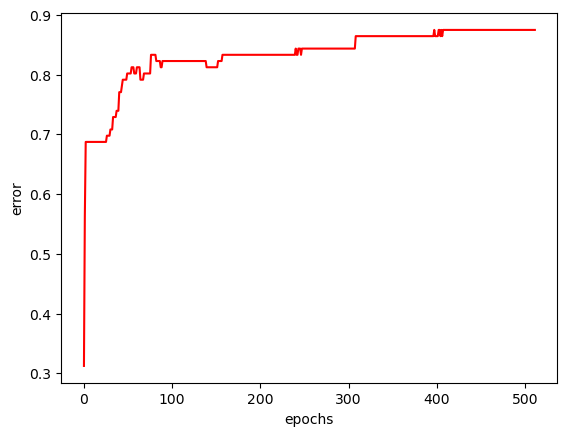

In [53]:
plt.xlabel('epochs')
plt.ylabel('error')

plt.plot(epochs, accuracy, 'r')
plt.show()

In [54]:
model.accuracy(train_instances, train_targets)

0.875

In [55]:
validation_instances = [element[0] for element in validation_set]
validation_targets = [element[1] for element in validation_set]
model.accuracy(validation_instances, validation_targets)

0.9166666666666666

In [56]:
test_instances = [element[0] for element in test_set]
test_targets = [element[1] for element in test_set]
model.accuracy(test_instances, test_targets)

0.8666666666666667